# Introduction to MPI

## Homework:

1. Review the MPI parallelization of the matrix multiplication problem in [this tutorial](https://afzalbadshah.medium.com/matrix-multiplication-on-multiple-processors-mpi4py-dce0cb4a6d53).
2. Using the code above, write a function which can multiply 2 random $N\times N$ matrices.
3. Select 3-4 values of $N$ (e.g., $N =$ 10, 100, 500, 1000) and record multiplication time in the following scenarios:
    - Serial multiplication on a PC.
    - Parallel multiplication on a PC.
    - Parallel multiplication in Colab.
    - Parallel multiplication on FABRIC / ACCESS / CloudLab / Hellbender.

Plot the simulation time dynamics of these scenarios on the same graph.

In [ ]:
!pip install mpi4py

In [ ]:
from mpi4py import MPI
import numpy as np
import time
import pandas as pd
import sys

In [ ]:
def matrix_multiply(A, B):
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [ ]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
parallel_options = [True, False]
location = 'Colab'
sizes = [10, 100, 250, 500, 750]

times = []
parallels = []
locations = []
mpi_sizes = []

for parallel in parallel_options:
    for N in sizes:
        start_time = time.time()
        if parallel:
            if rank == 0:
                print(f"size: {size}")
                # Master process: generate matrices and send parts to workers
                A = np.random.rand(N, N)
                B = np.random.rand(N, N)
                chunk_size = A.shape[0] // size
                A_chunks = [A[i:i+chunk_size] for i in range(0, A.shape[0], chunk_size)]
                
                # Send chunks to workers
                for i in range(1, size):
                    comm.send(A_chunks[i-1], dest=i, tag=1)
                    comm.send(B, dest=i, tag=2)
                
                # Compute master's chunk
                C_partial = matrix_multiply(A_chunks[0], B)
                
                # Gather results from workers
                for i in range(1, size):
                    C_partial += comm.recv(source=i, tag=3)
            else:
                # Worker processes: receive data, compute, and send result back
                A_chunk = comm.recv(source=0, tag=1)
                B = comm.recv(source=0, tag=2)
                C_partial = matrix_multiply(A_chunk, B)
                comm.send(C_partial, dest=0, tag=3)
        else:
            # Serial computation if parallel is False
            print(f"size: 1")
            A = np.random.rand(N, N)
            B = np.random.rand(N, N)
            C = matrix_multiply(A, B)
        end_time = time.time()
        
        # Only record times and print output on master
        if rank == 0:
            times.append(end_time - start_time)
            parallels.append(parallel)
            locations.append(location)
            if parallel:
                mpi_sizes.append(size)
            else:
                mpi_sizes.append(1)
            print(f"Execution time: {end_time - start_time} seconds for N = {N} and cores = {size if parallel else 1}")
            sys.stdout.flush()   
# Only master writes the CSV file
if rank == 0:
    df = pd.DataFrame({
        'Size of N for NxN': sizes * len(parallel_options),
        'Time': times,
        'Parallelization': parallels,
        'Location': locations,
        'mpi_size': mpi_sizes
    })
    df.to_csv(f"{location}Results.csv", index=False)
    print(f"Results written to {location}Results.csv")

C:\Users\nolan\AppData\Local\Temp\ipykernel_27308\3372992155.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if len(groups) <= 10 else 'tab20', len(groups))


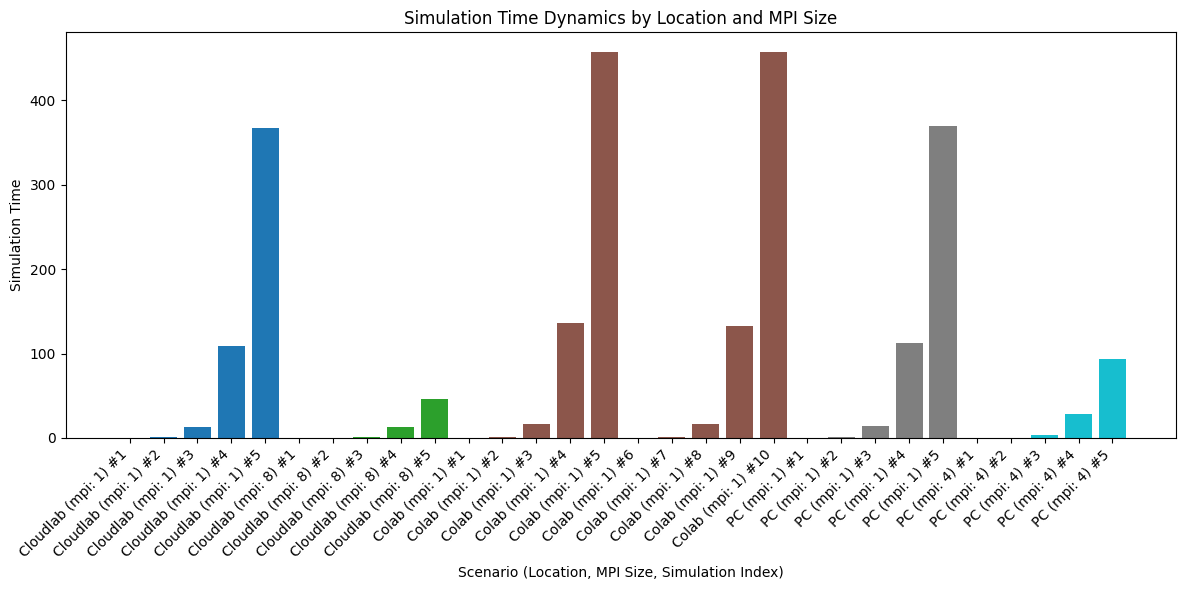

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('cominedResults.csv')

df['Simulation_Index'] = df.groupby(['Location', 'mpi_size']).cumcount() + 1

# Create a group identifier using Location and mpi_size
df['Group'] = df['Location'].astype(str) + ' (mpi: ' + df['mpi_size'].astype(str) + ')'

# Create a unique label for each simulation run
df['Scenario'] = df['Group'] + ' #' + df['Simulation_Index'].astype(str)

# Sort the dataframe for clarity in the plot
df = df.sort_values(by=['Location', 'mpi_size', 'Simulation_Index'])

# Generate a color mapping for each unique group
groups = df['Group'].unique()
# Use 'tab10' if there are 10 or fewer groups, otherwise 'tab20'
cmap = plt.cm.get_cmap('tab10' if len(groups) <= 10 else 'tab20', len(groups))
color_map = {group: cmap(i) for i, group in enumerate(groups)}

# Map the color for each row based on its group
df['Color'] = df['Group'].map(color_map)

# Plot each simulation as its own bar with the assigned group color
plt.figure(figsize=(12, 6))
plt.bar(df['Scenario'], df['Time'], color=df['Color'])
plt.xlabel('Scenario (Location, MPI Size, Simulation Index)')
plt.ylabel('Simulation Time')
plt.title('Simulation Time Dynamics by Location and MPI Size')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

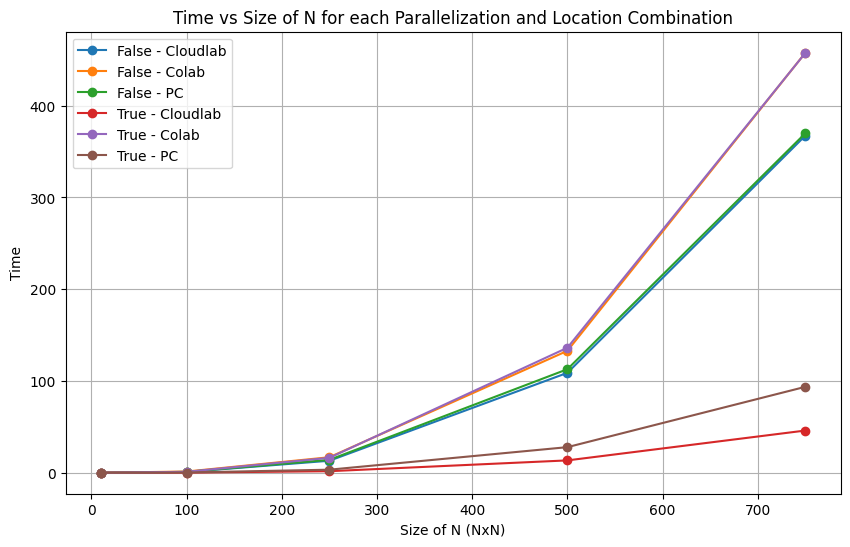

In [9]:
plt.figure(figsize=(10, 6))

# Group by the combination of Parallelization and Location.
groups = df.groupby(['Parallelization', 'Location'])

# Iterate through each group and plot Time versus Size of N.
for (parallel, location), group in groups:
    # Sort the group by the "Size of N for NxN" column so the line is drawn in order.
    group_sorted = group.sort_values(by="Size of N for NxN")
    plt.plot(group_sorted["Size of N for NxN"], group_sorted["Time"], marker='o',
             label=f"{parallel} - {location}")

# Label the axes and add a title.
plt.xlabel("Size of N (NxN)")
plt.ylabel("Time")
plt.title("Time vs Size of N for each Parallelization and Location Combination")

# Display the legend and grid.
plt.legend()
plt.grid(True)

# Show the plot.
plt.show()